# **GoodReads or BadReads?**

Given the review text and other information about it, you have to predict the rating associated with
that review. This is a classification problem. Rating 0, 1, 2, 3, 4, and 5 are the classes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import unicodedata
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import xgboost as xgb
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


The train.csv file is read and loaded onto a pandas dataframe

In [3]:


df = pd.read_csv('/content/drive/MyDrive/train.csv')
df = df.dropna(subset=['rating', 'review_text'])

In [27]:
df.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,5845f85c23e768f0636c9c7f77f3a529,7134202,55d9037adc00645b17f0cf43fa4d053e,"I ""read"" this as an audiobook. \n This book fo...",Tue Sep 12 17:14:59 -0700 2017,Tue Sep 12 17:24:30 -0700 2017,Mon Sep 11 00:00:00 -0700 2017,Sun Jan 01 00:00:00 -0800 2017,0,0,3
1,4251532f32b7e8b98912188f4d962eb1,2767052,e5f389a112b12d560e42e0c5c3d4eb35,Easily one of the best sci-fi books out there ...,Sat Mar 14 13:28:52 -0700 2009,Fri Mar 27 12:25:19 -0700 2009,NaN,NaN,0,0,5
2,2cabd95f62285fc08f4c544afaee5ea4,8492856,e7892549ac69653aceaac86760575aa0,Best. Sarah. Dessen. Book. Ever. And to anyone...,Tue Oct 23 05:51:53 -0700 2012,Sat May 18 02:19:43 -0700 2013,NaN,NaN,0,0,4
3,2d61d345434328a188f805ec75dde2c2,13206760,ab4acc9ad0a24a072356c331880b83d5,"This series just gets better and better, and S...",Thu Sep 03 14:18:43 -0700 2015,Thu Feb 18 07:11:43 -0800 2016,Sun Sep 06 16:42:33 -0700 2015,Thu Sep 03 00:00:00 -0700 2015,0,0,5
4,a3e696e6ced8daae338eccf12ac58053,7171637,0b65c86a90814e4ab5db50e0cd3dc808,For reviews on all the hottest to the underhyp...,Wed May 30 00:44:56 -0700 2012,Mon Mar 18 05:37:27 -0700 2013,Mon Mar 18 05:37:27 -0700 2013,Sun Mar 17 00:00:00 -0700 2013,0,0,5


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       630000 non-null  object
 1   book_id       630000 non-null  int64 
 2   review_id     630000 non-null  object
 3   review_text   630000 non-null  object
 4   date_added    630000 non-null  object
 5   date_updated  630000 non-null  object
 6   read_at       565775 non-null  object
 7   started_at    437963 non-null  object
 8   n_votes       630000 non-null  int64 
 9   n_comments    630000 non-null  int64 
 10  rating        630000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 52.9+ MB


The six classification classes are the ratings for a book numbered from 0,1,2,3,4,5

In [29]:
df.rating.unique()

array([3, 5, 4, 0, 2, 1])

## **Data Pre-Processing**

Data preprocessing is an integral part while performing any text analysis or NLP task.

We have undertaken the following steps for data preprocessing of the review text
1. Conversion of all text to lowercase
2. Removing HTML tags
3. Removing any special characters, punctuation marks etc, which are irrelevant to review ratings
4. **Tokenization**: In tokenization we split the text in to words 'tokens'
5. **Removal of Stopwords**: Stop-words in English language are words like a, an, the, this, that etc. These words do not impact whether the review is good or bad, hence are removed
6.**Lemmatization**: This is the process of grouping different forms of the same word together (improves, improving, improved etc)


In [4]:


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove numbers, punctuation, and special characters
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization (split the text into words)
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization (using WordNet Lemmatizer)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a single string
    processed_text = ' '.join(words)

    return processed_text


tqdm.pandas()


df['review_text'] = df['review_text'].progress_apply(preprocess_text)

  0%|          | 66/630000 [00:01<3:24:25, 51.36it/s] <ipython-input-4-e6b1618c39da>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
100%|██████████| 630000/630000 [18:15<00:00, 574.83it/s]


 **This is a multi-class classification problem. The class distribution might be skewed towards
higher ratings (1 star ratings are always rare). How would you tackle class imbalance?**

Here to solve this issue we use the Random Over Sampler provided by the sklearn library where we resample the data by Downsampling the Majority class by adding data points of minority classes. It increases the number of instances of the minority class by randomly duplicating existing instances until the classes are balanced.

In [5]:
# Downsample the majority class using RandomUnderSampler


ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['review_text']], df['rating'])

# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame({'review_text': X_resampled['review_text'], 'rating': y_resampled})

In [6]:
len(df_resampled)

1317486

The resampled data is split into train test splits for validation purposes.


Following that we use the **TF-IDF (Term Frequency-Inverse Document Frequency)** to extract meaningful features from the data.

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents (corpus). It is commonly used in natural language processing and information retrieval to extract meaningful features from text data. Here's a brief explanation of TF-IDF:

1. Term Frequency (TF): Term Frequency measures how frequently a term (word) appears in a document.
It is calculated as the ratio of the number of times a term appears in a document to the total number of terms in the document.

2. Inverse Document Frequency (IDF): Inverse Document Frequency measures the rarity of a term across a collection of documents.
It is calculated as the logarithm of the ratio of the total number of documents to the number of documents containing the term, plus one to avoid division by zero.

3. TF-IDF: TF-IDF is the product of TF and IDF, representing the importance of a term in a document relative to the entire corpus.
The formula for TF-IDF is given by: TF-IDF(t,d,D)=TF(t,d)×IDF(t,D)

In [10]:

X_train, X_test, y_train, y_test = train_test_split(df_resampled['review_text'], df_resampled['rating'], test_size=0.2, random_state=42)


vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    max_df=0.8,
    min_df=5,
    ngram_range=(1, 2),
    max_features=5000
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

KeyboardInterrupt: ignored

In [34]:
X_train_tfidf.shape[0]

922240

In [35]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [36]:
y_test.shape

(395246,)

In [8]:
X_test_tfidf.shape


(395246, 5000)

# Machine Learning

Now that we are done with the preprocessing and have extracted features using TF-IDF we apply various Machine Learning models for classification on our data.

Models Used:

1. Logistic Regression:

    1. max-iter=100
    2. max-iter=100, solver=lbfgs
    3. max-iter=200, solver=lbfgs
    4. max-iter=100, solver=newton-cg
    5. max-iter=100, solver=newton-cg, c=1.0

2. LinearSVC
3. SVM (rbf kernel)

Achieved the best results with the newton-cg solver

In [38]:

# Create and train the logistic regression model
logreg_model = LogisticRegression(max_iter=100, solver='newton-cg', C=1.0)
logreg_model.fit(X_train_tfidf , y_train)


y_pred = logreg_model.predict(X_test_tfidf)


y_pred = y_pred.astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")

Accuracy on the test set: 0.5296929001179013


In [39]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.49
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.49      0.52     65881
           1       0.55      0.60      0.58     65975
           2       0.45      0.43      0.44     65920
           3       0.42      0.40      0.41     65898
           4       0.40      0.40      0.40     65876
           5       0.54      0.60      0.57     65696

    accuracy                           0.49    395246
   macro avg       0.48      0.49      0.48    395246
weighted avg       0.48      0.49      0.48    395246



In [ ]:

model = LinearSVC()

# Train the model on the training data
model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.5253018998246666
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59     44024
           1       0.57      0.69      0.63     43892
           2       0.50      0.42      0.46     43854
           3       0.47      0.39      0.43     44004
           4       0.45      0.34      0.39     43904
           5       0.56      0.68      0.61     43820

    accuracy                           0.53    263498
   macro avg       0.52      0.53      0.52    263498
weighted avg       0.52      0.53      0.52    263498



In [49]:
X_test_tfidf.shape


(270000, 5000)

In [9]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score


# Initialize an XGBoost classifier
xgb_classifier = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)

# Train the classifier
xgb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.64      0.49     65881
           1       0.51      0.45      0.48     65975
           2       0.41      0.35      0.37     65920
           3       0.38      0.34      0.36     65898
           4       0.38      0.25      0.30     65876
           5       0.49      0.53      0.51     65696

    accuracy                           0.43    395246
   macro avg       0.43      0.43      0.42    395246
weighted avg       0.43      0.43      0.42    395246



# **Confusion Matrix**

The confusion matrix is shown below for the logistic regression model:

In [45]:

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ")
print(cm)



Confusion matrix: 
[[31997  9641  4774  4532  5993  8944]
 [ 6959 39734 13198  2997  1253  1834]
 [ 5103 14463 28041 12553  3714  2046]
 [ 4575  4145 12289 26625 13609  4655]
 [ 4671  2176  3100 13655 26313 15961]
 [ 4796  1898  1222  3400 14902 39478]]


<ipython-input-46-8540bdacc9f6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-46-8540bdacc9f6>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


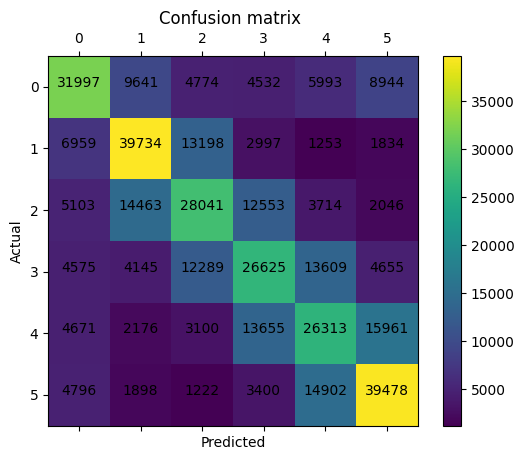

In [46]:

labels = ['0', '1', '2','3','4','5']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
tick_marks = np.arange(cm.shape[1])
plt.title('Confusion matrix ')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[0])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", )
plt.show()

In [ ]:
# df.to_csv('/content/drive/MyDrive/ML IIITB/preprocessed_data1.csv', index=False)

In [ ]:


# Define a range of C values to explore
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameter value
best_C = grid_search.best_params_['C']
print(f"Best value for C: {best_C}")

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)

# Evaluate the best model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_classification_rep = classification_report(y_test, y_pred_best)

# Print the results for the best model
print(f"Best Accuracy: {best_accuracy}")
print("Best Classification Report:")
print(best_classification_rep)


In [ ]:

svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

# Train the SVM model
svm_model.fit(X_train_tfidf, y_train)

# Predictions on the validation set
val_predictions = svm_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, val_predictions)
print(f"Accuracy on the test set: {accuracy}")

Loading the test.csv file and performing the same preprocessing techniques as used on the training data


In [40]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df = test_df.dropna(subset=['review_text'])
test_df.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,5f2ab1bb7faf49eee463cc95f9b7b359,8306857,a3286ad450d4b346ef8c0e4b264c5c1a,I honestly wasn't expecting much from this boo...,Tue May 15 10:36:28 -0700 2012,Sat May 28 10:19:40 -0700 2016,Wed May 16 00:00:00 -0700 2012,Tue May 15 00:00:00 -0700 2012,0,0
1,f7c07b030097a56de573b4e305264631,11735983,94a41ad0c55523947b53b9fa4c607e0c,I really enjoyed this book. It was well writte...,Sat Jul 06 07:04:14 -0700 2013,Wed Jul 24 14:25:44 -0700 2013,Wed Jul 24 14:25:44 -0700 2013,Sat Jul 06 00:00:00 -0700 2013,0,0
2,22e6aa6cb4425438f32a49c7cbcb070a,22928964,0d8a96bbf96cf08d399234145f68c04c,I am so thrilled to be finally reading this bo...,Sat Nov 01 06:22:23 -0700 2014,Thu Nov 10 10:01:13 -0800 2016,Mon Jun 01 00:00:00 -0700 2015,Thu May 28 00:00:00 -0700 2015,38,6
3,353521b7d7f0772699df2a0e1d7b85d2,6597651,d8a1206d0f6cbebd581b21d4b4aab452,The premise of this book was right up my alley...,Mon May 09 15:09:59 -0700 2011,Fri Jul 08 15:21:09 -0700 2011,Tue Mar 01 00:00:00 -0800 2011,NaN,0,0
4,1cb74e81643ae2af8d7900c6802cde4d,10866624,ef216c7548ea239f82f966d1e7aa79e2,"So, I am a fan of genre-y novels, and as such ...",Mon Oct 01 07:02:33 -0700 2012,Wed Oct 03 09:48:25 -0700 2012,Mon Oct 01 00:00:00 -0700 2012,Mon Oct 01 00:00:00 -0700 2012,1,0


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       270000 non-null  object
 1   book_id       270000 non-null  int64 
 2   review_id     270000 non-null  object
 3   review_text   270000 non-null  object
 4   date_added    270000 non-null  object
 5   date_updated  270000 non-null  object
 6   read_at       242459 non-null  object
 7   started_at    187740 non-null  object
 8   n_votes       270000 non-null  int64 
 9   n_comments    270000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 20.6+ MB


In [41]:
tqdm.pandas()
test_df['review_text'] = test_df['review_text'].progress_apply(preprocess_text)

  0%|          | 27/270000 [00:00<17:09, 262.21it/s]<ipython-input-30-e6b1618c39da>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
100%|██████████| 270000/270000 [07:32<00:00, 596.15it/s]


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       270000 non-null  object
 1   book_id       270000 non-null  int64 
 2   review_id     270000 non-null  object
 3   review_text   270000 non-null  object
 4   date_added    270000 non-null  object
 5   date_updated  270000 non-null  object
 6   read_at       242459 non-null  object
 7   started_at    187740 non-null  object
 8   n_votes       270000 non-null  int64 
 9   n_comments    270000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 20.6+ MB


**Using the TF-IDF for testing data as well**


In [42]:
X_test_tfidf = vectorizer.transform(test_df['review_text'])

**Creating the predictions for the test data for our model**

In [43]:
y_pred_test = nb_classifier.predict(X_test_tfidf )

y_pred_test = y_pred_test.astype(int)

In [44]:
result_df = pd.DataFrame({
    'review_id': test_df['review_id'],
    'rating': y_pred_test
})


result_df.to_csv('/content/drive/MyDrive/NB_submission.csv', index=False, columns=["review_id", "rating"])

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/LinearSVC_submission.csv')

In [ ]:
test_df.shape

(270000, 2)